# Hate Speech Detection Using NLTK and Implemented Naive Bayes Classifier
### Daniyal Mehraeen

### Part a)

In [34]:
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [35]:
data = pd.read_csv("./hatredTweets (2).csv")

data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [36]:
# Moving the label to the last column
data = data[["id","tweet","label"]]

data.head()

,id,tweet,label
0,1,@user when a father is dysfunctional and is s...,0
1,2,@user @user thanks for #lyft credit i can't us...,0
2,3,bihday your majesty,0
3,4,#model i love u take with u all the time in ...,0
4,5,factsguide: society now #motivation,0


In [37]:
data.shape

(31962, 3)

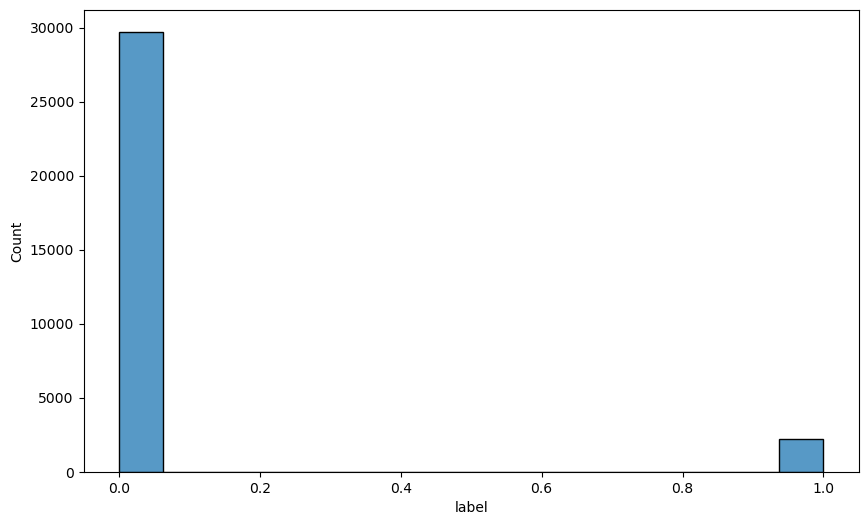

In [38]:
plt.figure(figsize=(10,6))

sns.histplot(x=data["label"])
plt.show()

### Part b)

In [39]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mehra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mehra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mehra\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
# Defining a function to convert NLTK's POS tags to WordNet's POS tags
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# Initializing lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Converting to lowercase
    text = text.lower()

    # Remove non-UTF-8 characters
    text = text.encode("utf-8", errors="ignore").decode()
    
    # Tokenizing the text
    word_tokens = word_tokenize(text)
    
    # Removing punctuations
    word_tokens = [word for word in word_tokens if word.isalpha()]
    
    # Removing stopwords and articles
    stop_words = set(stopwords.words('english'))
    word_tokens = [word for word in word_tokens if word not in stop_words]

    # Lemmatize
    nltk_tagged = nltk.pos_tag(word_tokens)  
    wordnet_tagged = map(lambda x: (x[0], get_wordnet_pos(x[1])), nltk_tagged)
    lemmatized_words = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_words.append(word)
        else:        
            lemmatized_words.append(lemmatizer.lemmatize(word, tag))
    
    return " ".join(lemmatized_words)

# Applying the preprocessing function to the text column
data['tweet'] = data['tweet'].apply(preprocess_text)

In [41]:
data.groupby(["label"]).count()

,id,tweet
label,,
0,29720,29720
1,2242,2242


### Part c)

#### Feature Extraction from tweets

In [42]:
# Create a CountVectorizer object for BoW representation
vectorizer = CountVectorizer()

# Fit the vectorizer on the tweets to learn the vocabulary
vectorizer.fit(data["tweet"])

# Transform the tweets into BoW feature vectors
feature_vectors = vectorizer.transform(data["tweet"])

In [43]:
data = pd.concat([pd.DataFrame(feature_vectors.toarray()), data.iloc[:,-1]], axis=1)

In [44]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,31976,31977,31978,31979,31980,31981,31982,31983,31984,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
print(data.shape)
print()
print(data.sum(axis=0))
print()
print(data.sum(axis=1))
print()

data.isna().sum().sum()

(31962, 31986)

0           2
1           3
2           1
3           1
4           1
         ... 
31981       1
31982       1
31983       1
31984       2
label    2242
Length: 31986, dtype: int64

0         8
1        14
2         2
3         4
4         3
         ..
31957     4
31958    14
31959     8
31960     9
31961     3
Length: 31962, dtype: int64



0

In [46]:
# Defining the target variable column
target_variable = "label"

# Performing stratified sampling to split the dataset
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=0.1, stratify=data[target_variable], random_state=42)

In [76]:
def calculate_probabilities(X, y):
    
    num_features = X.shape[1]
    class_probabilities = y.value_counts(normalize=True)
    
    classes = y.unique()
    num_classes = len(classes)

    num_examples, num_features = X.shape
    features_probs = []

    for c in range(num_classes):
        features_probs.append([])
        class_examples = X[y == c]
        for feature_index in range(num_features):
            feature_values, feature_counts = np.unique(class_examples.iloc[:, feature_index], return_counts=True)
            total_counts = np.sum(feature_counts)
            feature_prob = feature_counts / total_counts
            features_probs[c].append({value: prob for value, prob in zip(feature_values,feature_prob)})

    return class_probabilities, features_probs
class_probabilities, conditional_probabilities = calculate_probabilities(X_train, y_train)


In [83]:
class_probabilities = dict(class_probabilities)

In [80]:
def predict(X, class_probabilities, conditional_probabilities):
    num_examples = X.shape[0]
    num_features = X.shape[1]
    num_classes = len(class_probabilities)

    predictions = np.zeros(num_examples)

    missing_prob_cnt = 0

    for i in range(num_examples):

        print(f"\rPredicting [ {((i+1)/num_examples)*100: .2f}% ]", end="")
        
        row = X.iloc[i]
        max_posterior = -np.inf
        predicted_class = None
        for c in range(num_classes):
            posterior = np.log(class_probabilities[c])
            for feature_index in range(num_features):
                feature_value = row[feature_index]
                if feature_value in conditional_probabilities[c][feature_index].keys():
                    posterior += np.log(conditional_probabilities[c][feature_index][feature_value])
                else:
                    # Handling Missiong Probabilities (laplace smoothing)
                    missing_prob_cnt += 1
                    posterior += np.log(1e-6)
            if posterior > max_posterior:
                max_posterior = posterior
                predicted_class = c
        predictions[i] = predicted_class

    print()
    print(f"{missing_prob_cnt} Missing Probabilities Handled")
    return predictions

y_pred = predict(X_test,class_probabilities, conditional_probabilities)

print()
print("Predicting Completed")

Predicting [  100.00% ]
11376 Missing Probabilities Handled

Predicting Completed


### Part d)

In [81]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\tAccuracy: {accuracy*100: .2f}%")
print(f"\tPrecision: {precision*100: .2f}%")
print(f"\tRecall: {recall*100: .2f}%")
print(f"\tF1: {f1*100: .2f}%")

	Accuracy:  95.71%
	Precision:  72.77%
	Recall:  62.05%
	F1:  66.99%
